In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

from torch.utils.data import DataLoader

from utility.ffqd_mnist import FFQD_Dataset, label_for_id

## Load Data


In [2]:
training_data = FFQD_Dataset('ffqd_mnist/', train=True)
train_dataloader = DataLoader(training_data, batch_size=64)

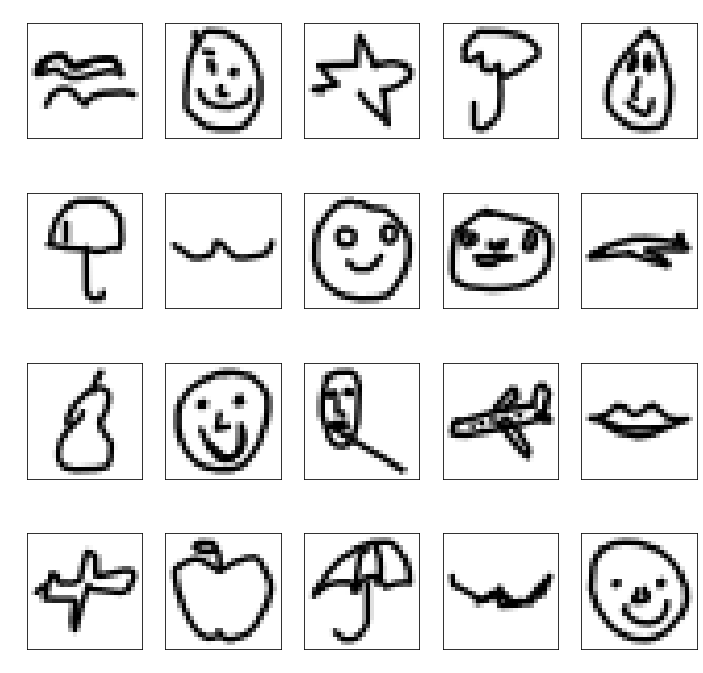

In [3]:
def sample_images(start=1, end=20):
    fig, axs = plt.subplots(4, 5, figsize=(12, 12))
    axs = axs.flatten()
    for i in range(start, end):
        axs[i - start].imshow(
            torch.Tensor(training_data.images[i]).view(28, 28), cmap="gray_r")
        label_id = np.argmax(training_data.img_labels[i])
        axs[i - start].set_title(
            f' label {label_id} -- {label_for_id(label_id)} ')


sample_images(100, 120)

In [5]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")

Feature batch shape: torch.Size([64, 784])


# Neural Network -- Simple Perceptron


In [6]:
# https://mlfromscratch.com/neural-network-tutorial/#/
def sigmoid(x, derivative=False):
    if derivative:
        return (np.exp(-x)) / ((np.exp(-x) + 1) ** 2)
    return 1 / (1 + np.exp(-x))


def softmax(x, derivative=False):
    # Numerically stable with large exponentials
    exps = np.exp(x - x.max())
    if derivative:
        return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
    return exps / np.sum(exps, axis=0)


def relu(x, derivative=False):
    if derivative:
        dx = np.ones_like(x)
        dx[x <= 0] = 0
        return dx
    else:
        return np.maximum(0, x)

def x_entropy(y_pred, y_truth, derivative=False):
    if derivative:
        return np.where(y_truth == 1, -1 / y_pred.clip(min=1e-8), 0)
    else:
        return -np.sum(y_truth*np.log(y_pred.clip(min=1e-8)))/(y_pred.shape[0])


In [7]:
def forward_pass(x_train, params):
    # input layer activations becomes sample
    params['A0'] = x_train

    # input layer to hidden layer 1
    params['Z1'] = np.dot(params["W1"], params['A0'])
    # params['A1'] = softmax(params['Z1'])
    params['A1'] = relu(params['Z1'])
    # params['A1'] = params['Z1']
    return params['A1']


In [8]:
def backward_pass(y_train, output, params):
    change_w = {}

    # Calculate W1 update -- MSE loss
    # error = 2 * (output - y_train) / output.shape[0] * softmax(params['Z1'],
    #                                                            derivative=True)
    # error = 2 * (output - y_train) / output.shape[0] * relu(params['Z1'],
    #                                                            derivative=True)

    # X-entropy
    backward_loss = x_entropy(output, y_train, derivative=True)
    backward_activation = backward_loss * relu(
        params['Z1'], derivative=True)

    change_w['W1'] = np.outer(backward_activation, params['A0'])

    return change_w

In [9]:
def update_network_parameters(changes_to_w, params):
    '''
        Update network parameters according to update rule from
        Stochastic Gradient Descent.

        θ = θ - η * ∇J(x, y),
            theta θ:            a network parameter (e.g. a weight w)
            eta η:              the learning rate
            gradient ∇J(x, y):  the gradient of the objective function,
                                i.e. the change for a specific theta θ
    '''
    l_rate = 0.1

    for key, value in changes_to_w.items():
        params[key] -= l_rate * value

In [10]:

def compute_accuracy(x_val, y_val, params):
    '''
        This function does a forward pass of x, then checks if the indices
        of the maximum value in the output equals the indices in the label
        y. Then it sums over each prediction and calculates the accuracy.
    '''
    predictions = []

    for x, y in zip(x_val, y_val):
        output = forward_pass(x, params)
        pred = np.argmax(output)
        predictions.append(pred == np.argmax(y))

    return np.mean(predictions)

In [11]:
import time


def train(x_val, y_val,p, end_iteration=-1, start_iteration=1,  silent=False):
    start_time = time.time()
    iteration = start_iteration
    accuracy = -1
    params = p
    for (x_train, y_train) in train_dataloader:
        # for iteration in range(self.epochs):
        for x, y in zip(x_train.numpy(), y_train.numpy()):
            output = forward_pass(x, params)
            changes_to_w = backward_pass(y, output, params)
            update_network_parameters(changes_to_w, params)

        if not silent:
            accuracy = compute_accuracy(x_val, y_val, params)
            print('Batch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration + 1, time.time() - start_time, accuracy * 100
            ))

        iteration += 1
        if iteration == end_iteration:
            break
    if silent:
        accuracy = compute_accuracy(x_val, y_val, params)
    return accuracy

In [16]:
def train_the_model():
    params = {
        'W1': np.random.randn(10, 28 * 28) * np.sqrt(1. / 10)
    }
    # observe_cat = 8

    test_data = FFQD_Dataset('ffqd_mnist/', train=False)

    for i in range(20):
        acc = train(test_data.images, test_data.img_labels,params,
                    end_iteration=(i + 1) * 50,
                    start_iteration=i * 50,  silent=True)
        print(acc)
train_the_model()


0.2594
0.4099
0.4713
0.5136
0.5478
0.5794
0.6025
0.618
0.6312
0.6413
0.6473
0.6541
0.6579
0.6603
0.6631
0.6656
0.6675
0.6684
0.6696
0.6707


 # And now ?
<pre>






















</pre>

trained: 0.6163


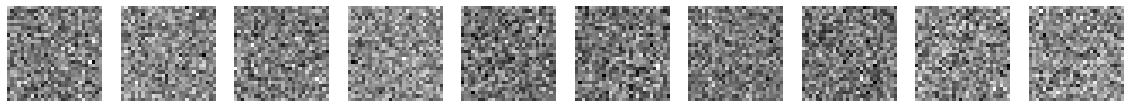

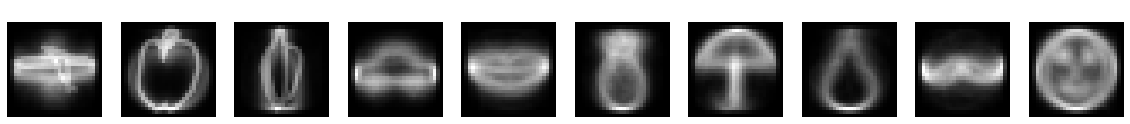

trained: 0.654


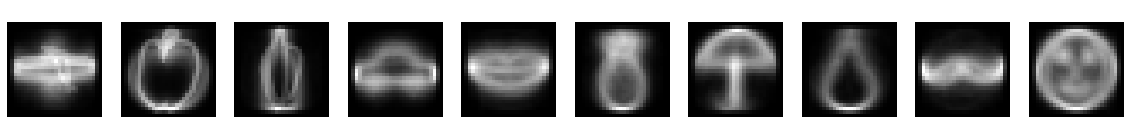

trained: 0.6677


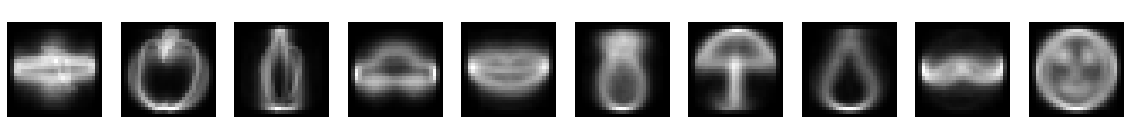

trained: 0.6762


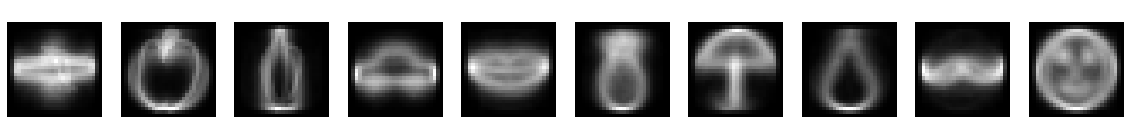

trained: 0.6798


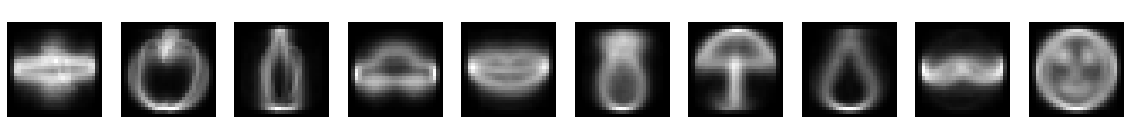

trained: 0.683


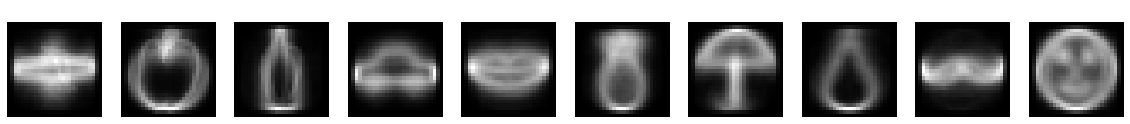

trained: 0.6849


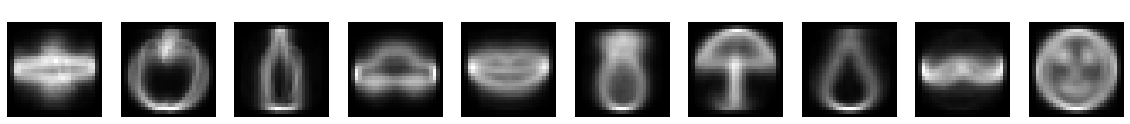

trained: 0.687


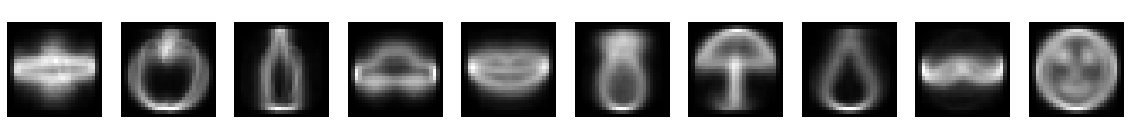

trained: 0.6886


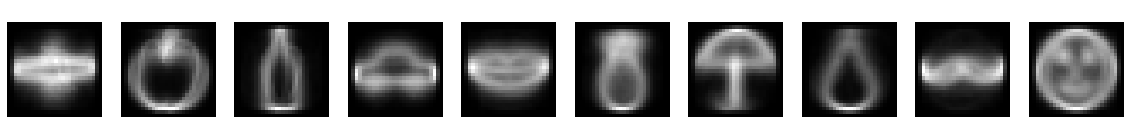

trained: 0.6896


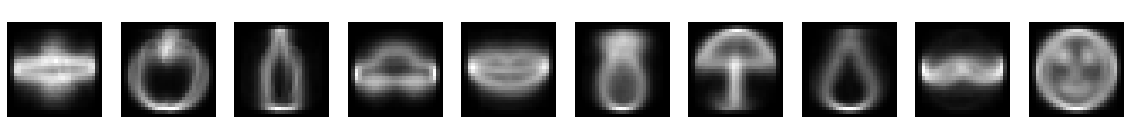

In [19]:
def simple_xai():
    params = {
        'W1': np.random.randn(10, 28 * 28) * np.sqrt(1. / 10)
    }

    test_data = FFQD_Dataset('ffqd_mnist/', train=False)

    original = np.array(params["W1"])
    fig, axs = plt.subplots(1, 10, figsize=(20, 12))
    axs = axs.flatten()
    for ii in range(10):
            pcm = axs[ii].imshow(
                torch.Tensor((original[ii])).view(28, 28),
                cmap="gray")
            axs[ii].axis('off')
    for i in range(10):
        # original = np.array(params["W1"])
        acc = train(test_data.images, test_data.img_labels, params,
                    end_iteration=(i + 1) * 200,
                    start_iteration=i * 200, silent=True)
        print(f"trained: {acc}")
        fig, axs = plt.subplots(1, 10, figsize=(20, 12))
        axs = axs.flatten()
        for ii in range(10):
            pcm = axs[ii].imshow(
                torch.Tensor(((params["W1"][ii] -original[ii]).clip(min=0) )).view(28, 28),
                cmap="gray")
            # fig.colorbar(pcm, ax= axs[ii])
            axs[ii].set_title(f' label {ii}')
            axs[ii].axis('off')
        plt.show()
simple_xai()
